# LIBRARY IMPORT

In [ ]:
!pip install -i https://test.pypi.org/simple/ bitsandbytes

In [ ]:
!pip install transformers[torch] datasets -q


In [ ]:
!pip install rouge

In [ ]:
import pandas as pd


In [ ]:
# pip install accelerate bitsandbytes
import torch
import requests
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl", load_in_8bit=  True, device_map="auto")

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

question = "how many dogs are in the picture?"
inputs = processor(raw_image, question, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)


model-00001-of-00002.safetensors:   0%|          | 0.00/9.44G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.33G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor,Blip2ForConditionalGeneration,Blip2Processor,BlipForConditionalGeneration
from transformers import BlipConfig
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pyarrow as pa
from  PIL import Image
import cv2
import PIL
import accelerate

#LOAD DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
df=pd.read_csv('dataset_v2.csv')

In [ ]:
df['path'] = df['path'].apply(lambda x: x.replace("\\", "/"))

In [ ]:
df['path'] = df['path'].apply(lambda x: x.replace( "./data/imgs",'/content/drive/MyDrive/Independent study/Images'))

In [ ]:
len(df)

9416

In [ ]:
df_train=df[:8681]

In [ ]:
df_test=df[8681:]

# Build dataset

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)

import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, questions, answers, image_paths, processor):
        self.questions = questions
        self.answers = answers
        self.image_paths = image_paths
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        # get image + text
        question = self.questions[idx]
        answer = self.answers[idx]
        image = Image.open(self.image_paths[idx]).convert("RGB")
        text = question

        encoding = self.processor(image, text, padding="max_length", max_length= 128,truncation=True, return_tensors="pt")
        labels = self.processor.tokenizer.encode(
            answer, max_length= 128, pad_to_max_length=True, return_tensors='pt'
        )
        encoding["labels"] = labels.squeeze(0)
        encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)
        encoding["input_ids"] = encoding["input_ids"].squeeze(0)
        encoding["attention_mask"] = encoding["attention_mask"].squeeze(0)

        # remove batch dimension
        # for k,v in encoding.items():  encoding[k] = v.squeeze()
        return encoding

from torch.utils.data import DataLoader
from tqdm import tqdm

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    return batch




In [ ]:
df_train=df_train.sample(frac=1).reset_index(drop=True)

In [ ]:
questions = df_train['question'].to_list()
answers = df_train['answer'].to_list()
image_paths = df_train['path'].to_list()

train_dataset = VQADataset(questions = questions,
                          answers = answers,
                          image_paths = image_paths,
                          processor=processor)


In [ ]:
questions = df_test['question'].to_list()
answers = df_test['answer'].to_list()
image_paths = df_test['path'].to_list()


test_dataset = VQADataset(questions = questions,
                          answers = answers,
                          image_paths = image_paths,
                          processor=processor)

In [ ]:
len(train_dataset)

8681

In [ ]:
len(test_dataset)

735

In [ ]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch



In [ ]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=5, shuffle=False)


In [ ]:
batch = next(iter(train_dataloader))


In [ ]:
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)


In [ ]:
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  What does the learned model represent?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Answer:  It represents the output from the training process, used to make predictions.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

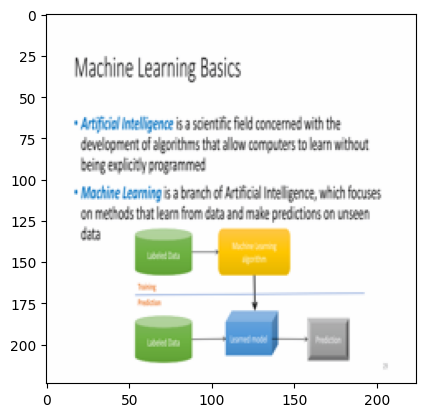

In [ ]:
batch_idx = 0

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

In [ ]:
batch_size = 100
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)



# MODEL TRAIN

In [ ]:
model_root='/content/drive/MyDrive/Independent study/model_VERSION6.pt'

In [ ]:
model.load_state_dict(torch.load(model_root))


In [ ]:
model.cuda()

In [ ]:
df_report=pd.read_csv('/content/drive/MyDrive/Independent study/report2.csv')

In [ ]:
df_report

In [ ]:
min_loss=100000

In [ ]:
df_report=pd.DataFrame(columns=['epoch','loss'])

In [ ]:
df_report

In [ ]:
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl", load_in_8bit=  True, device_map="auto")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model.train()


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear8bitLt(in_features=1408, out_features=4224, bias=True)
            (projection): Linear8bitLt(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear8bitLt(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear8bitLt(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post

In [ ]:
try :
 for epoch in range(10):
    print(f"Epoch: {epoch}")
    total_loss = []
    try :
     for batch in tqdm(train_dataloader):

        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}
        del batch['attention_mask']

        # zero the parameter gradients
        # forward + backward + optimizeыа
        optimizer.zero_grad()


        outputs = model(**batch)
        loss = outputs.loss


        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()


    except FileNotFoundError:
        print("The file was not found.")



    if np.mean(total_loss)<min_loss:
            min_loss=np.mean(total_loss)
            torch.save(model.state_dict(), '/content/drive/MyDrive/Independent study/model_VERSION6.pt')


    print("Loss:", np.mean(total_loss))

    df_report=df_report.append({'epoch':epoch,'loss':np.mean(total_loss)},ignore_index=True)
    df_report.to_csv('/content/drive/MyDrive/Independent study/report6.csv')
except FileNotFoundError:
        print("The file was not found.")

Epoch: 0


100%|██████████| 1737/1737 [46:51<00:00,  1.62s/it]


Loss: 40.50397596430628


<ipython-input-36-5f5a77207378>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_report=df_report.append({'epoch':epoch,'loss':np.mean(total_loss)},ignore_index=True)


Epoch: 1


  0%|          | 0/1737 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1737/1737 [34:55<00:00,  1.21s/it]
<ipython-input-36-5f5a77207378>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_report=df_report.append({'epoch':epoch,'loss':np.mean(total_loss)},ignore_index=True)


Loss: 40.50160118019574
Epoch: 2


  0%|          | 0/1737 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1737/1737 [34:53<00:00,  1.21s/it]
<ipython-input-36-5f5a77207378>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_report=df_report.append({'epoch':epoch,'loss':np.mean(total_loss)},ignore_index=True)


Loss: 40.50677353195164
Epoch: 3


  0%|          | 0/1737 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1737/1737 [34:55<00:00,  1.21s/it]
<ipython-input-36-5f5a77207378>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_report=df_report.append({'epoch':epoch,'loss':np.mean(total_loss)},ignore_index=True)


Loss: 40.53615248992516
Epoch: 4


  0%|          | 0/1737 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1737/1737 [34:57<00:00,  1.21s/it]
<ipython-input-36-5f5a77207378>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_report=df_report.append({'epoch':epoch,'loss':np.mean(total_loss)},ignore_index=True)


Loss: 40.466690054691995
Epoch: 5


  0%|          | 0/1737 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1737/1737 [35:07<00:00,  1.21s/it]
<ipython-input-36-5f5a77207378>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_report=df_report.append({'epoch':epoch,'loss':np.mean(total_loss)},ignore_index=True)


Loss: 40.50924726540011
Epoch: 6


  0%|          | 0/1737 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
 31%|███▏      | 545/1737 [10:59<24:03,  1.21s/it]

The file was not found.


RuntimeError: ignored

In [ ]:
 torch.save(model.state_dict(), '/content/drive/MyDrive/Independent study/model_version2_1.pt')

In [ ]:
df_report=pd.read_csv('report5 - report5.csv')

In [ ]:
df_report

,epoch,loss
0,0.0,40.525628
1,1.0,40.510723
2,2.0,40.520806
3,3.0,40.487065
4,4.0,40.525115
5,5.0,40.501925


In [ ]:
df_report['loss']=df_report['loss'].astype(float)

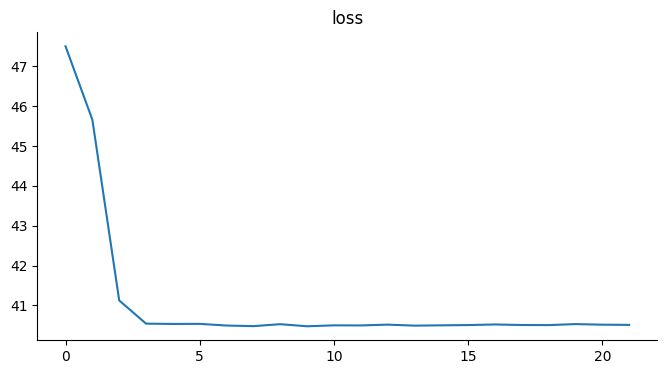

In [ ]:
from matplotlib import pyplot as plt
df_report['loss'].plot(kind='line', figsize=(8, 4), title='loss')
plt.gca().spines[['top', 'right']].set_visible(False)

# OUTCOMES

In [ ]:
def remove_repeated_phrases(sentence):
    words = sentence.split()
    # Check each possible phrase length
    for phrase_length in range(1, len(words) // 2 + 1):
        # Iterate over the sentence
        i = 0
        while i + phrase_length * 2 <= len(words):
            # Check if next phrase is a repeat
            if words[i:i + phrase_length] == words[i + phrase_length:i + 2 * phrase_length]:
                # Remove the repeated phrase
                del words[i + phrase_length:i + 2 * phrase_length]
            else:
                i += 1
    return ' '.join(words)

# Re-test the function


In [ ]:
def delete_after_comma_if_no_period(sentence):
    # Check if the sentence ends with a period
    if not sentence.endswith('.'):
        # Split the sentence at the comma
        parts = sentence.split(',', 1)
        # Return the part before the comma if there is only one word after the comma
        if len(parts) > 1 and len(parts[1].split()) <= 1:
            return parts[0]
        else:
            return sentence
    else:
        # Return the sentence as it is if it ends with a period
        return sentence


In [ ]:
def  show_predition(batch_idx, model, dataset, explain_slide=False):
  train_dataset=dataset
  sample = train_dataset[batch_idx]



  if explain_slide==True:
    sample2 = train_dataset[490]


    print("Question: Can you explain this slide?")
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}
    sample2 = {k: v.unsqueeze(0).to(device) for k,v in sample2.items()}
    input_ids=sample2['input_ids']


  else:
      print("Question: ",processor.decode(sample['input_ids'], skip_special_tokens=True))
      sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}
      input_ids=sample['input_ids']





  # forward pass
  outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=input_ids)
  print("Predicted Answer: ",delete_after_comma_if_no_period(remove_repeated_phrases(processor.decode(outputs[0],skip_special_tokens=True))))
  print("Actual Answer: ",processor.decode(sample['labels'][0], skip_special_tokens=True))
  #########################################################################
  unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
  unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
  unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
  plt.imshow(Image.fromarray(unnormalized_image))



## Train

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Question:  What does the learned model represent?


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer:  machine learning basics is a scientific field concerned with the development of algorithms that learn
Actual Answer:  It represents the output from the training process, used to make predictions.


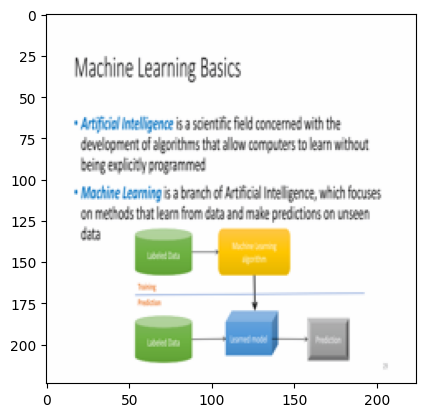

In [ ]:
 show_predition(0,model,train_dataset)

Question:  Can you explain this slide?
Predicted Answer:  linear swm mathematically
Actual Answer:  Slide explains Linear SVM: Margin calculated by scalar projection of pos. and neg. examples on unit normal vector. Margin width = 2/||w||.


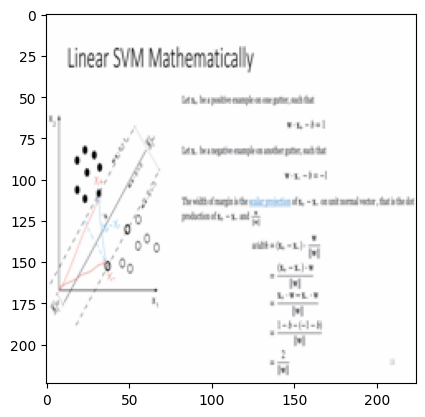

In [ ]:
 show_predition(200,model,train_dataset)

Question:  What do the equations at the bottom represent?
Predicted Answer:  ei for genus m
Actual Answer:  They detail how to compute the updated parameters in the Maximization step.


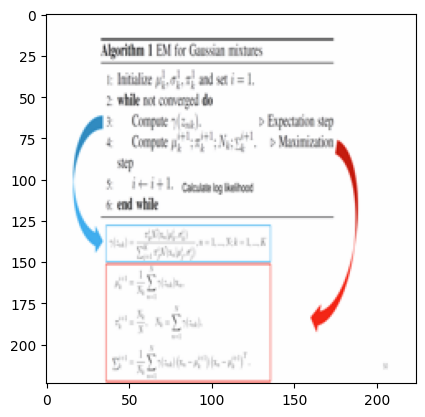

In [ ]:
 show_predition(300,model,train_dataset)

Question:  What is the primary difference between hard and soft margin?
Predicted Answer:  hard margin vs soft margin
Actual Answer:  Hard margin requires perfect separation of classes. Soft margin allows some misclassifications using slack variables.


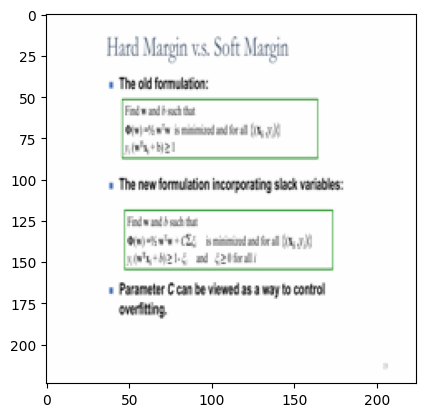

In [ ]:
 show_predition(1150,model,train_dataset)

Question:  What is the range of outputs for logistic regression?
Predicted Answer:  classification y 0
Actual Answer:  For logistic regression, outputs range from 0 to 1.


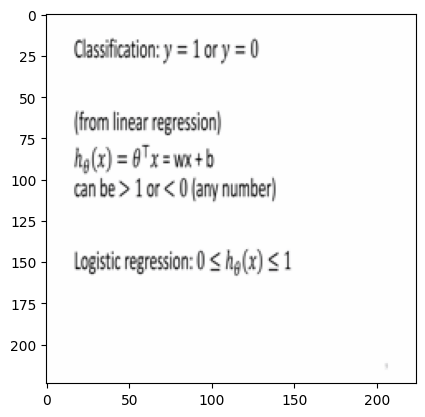

In [ ]:
 show_predition(1234,model,train_dataset)

Question:  How does the SVM decide the boundary?
Predicted Answer:  svm - wikipedia
Actual Answer:  SVM decides the boundary by finding a hyperplane that maximizes the margin between the two classes while correctly classifying all training data.


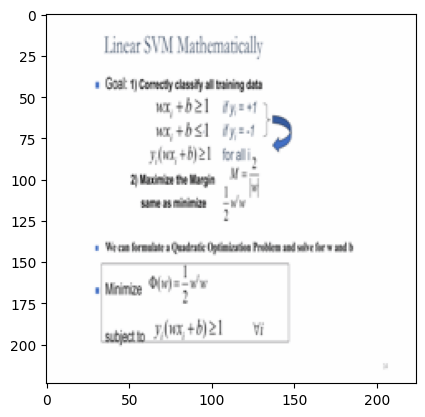

In [ ]:
show_predition(2345,model,train_dataset)

Question:  What is the principal eigenvalue?
Predicted Answer:  single value decomposition
Actual Answer:  The principal eigenvalue is the first and largest eigenvalue, associated with an orthonormal eigenvector.


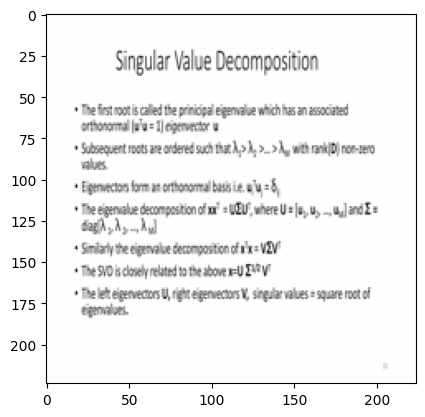

In [ ]:
show_predition(768,model,train_dataset)

Question:  What is the goal of the Method of Least Squares?
Predicted Answer:  a method of least squares is a method of least squares
Actual Answer:  The goal is to minimize the sum of squared differences for best fit.


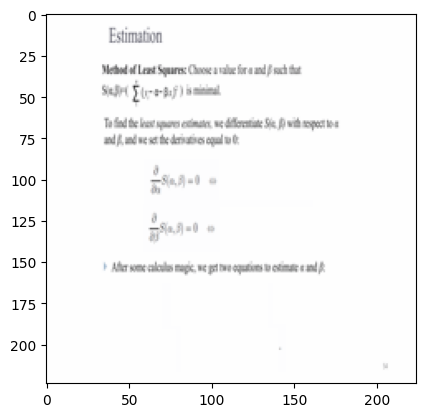

In [ ]:
show_predition(46,model,train_dataset)

Question:  Highlight the main points of this slide.
Predicted Answer:  properties of swm properties
Actual Answer:  Main points: SVM's flexibility, efficiency with big data, vast feature space management, overfitting control, unique math property, and feature selection.


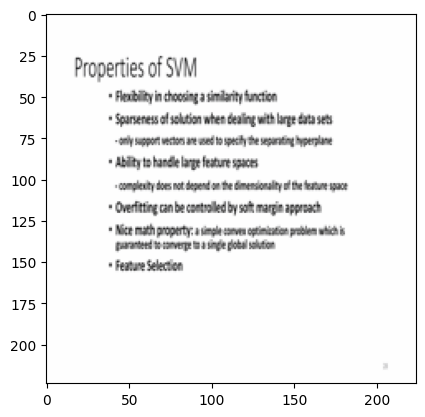

In [ ]:
show_predition(4567,model,train_dataset)

Question:  How is Bayes' theorem used in the context of this slide?
Predicted Answer:  maximum likelihood estimation
Actual Answer:  Bayes' theorem is used to relate the probability of a model given data to the probability of data given a model.


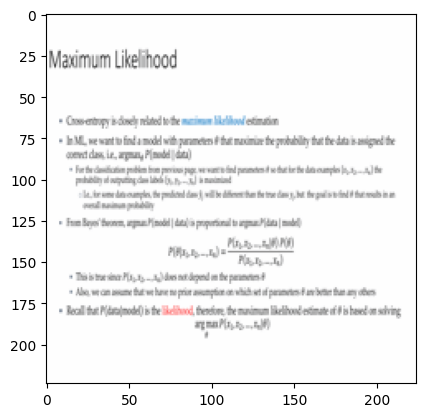

In [ ]:
show_predition(4532,model,train_dataset, model)

Question:  Is EM an iterative process?
Predicted Answer:  a lm is a process that can find maximum likelihood estimates of parameters of probabil
Actual Answer:  Yes, EM is an iterative optimization method.


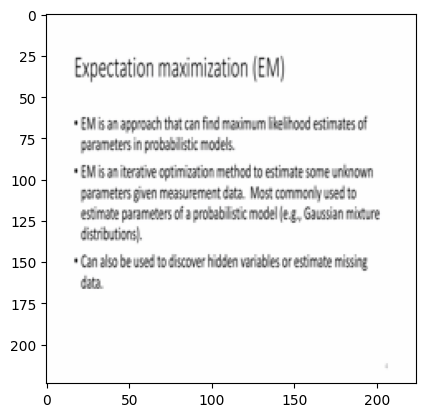

In [ ]:
show_predition(234,model,train_dataset)

## Test

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Question:  Why is it important that predictors have uncorrelated errors?


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer:  a bagging detail is a feature that is observed by drawing an example from a
Actual Answer:  It prevents consistent biases across models, making the ensemble more resistant to specific errors.


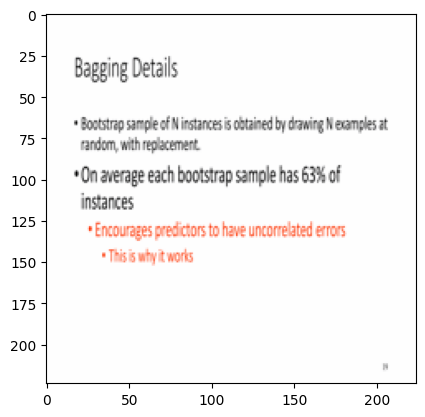

In [ ]:
 show_predition(200,model,test_dataset)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Question:  Which job position is 'Capital One' recruiting for?


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer:  machine learning engineer data scientist
Actual Answer:  Capital One is recruiting for the 'Machine Learning Engineer' position.


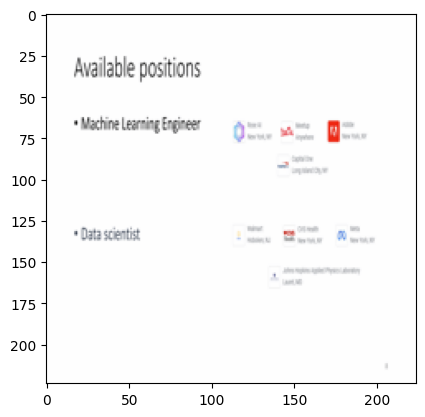

In [ ]:
 show_predition(700,model,test_dataset)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Question:  Can you explain this slide?


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer:  loss functions for x
Actual Answer:  The slide showcases different loss functions, their equations, and their behavior in terms of correct and incorrect classification.


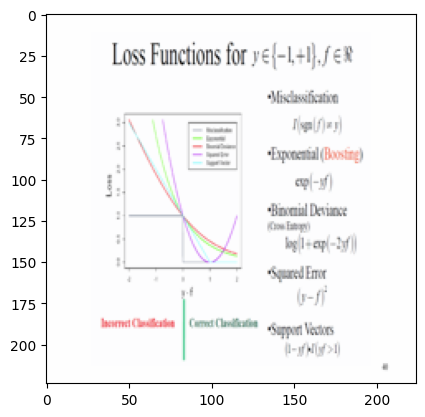

In [ ]:
 show_predition(410,model,test_dataset)

Question:  Is boosting about ignoring easy instances?
Predicted Answer:  5 a boosting practice is created by a boosted sample of training
Actual Answer:  No, boosting doesn't ignore easy instances, but it gives more attention to difficult ones.


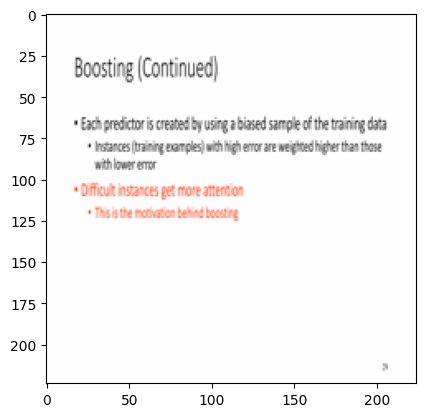

In [ ]:
 show_predition(300,model,test_dataset)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Question:  Can you explain this slide?


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer:  general idea
Actual Answer:  The slide presents the ensemble learning process. It starts with creating multiple datasets, then building multiple classifiers, and finally combining the classifiers for a unified result.


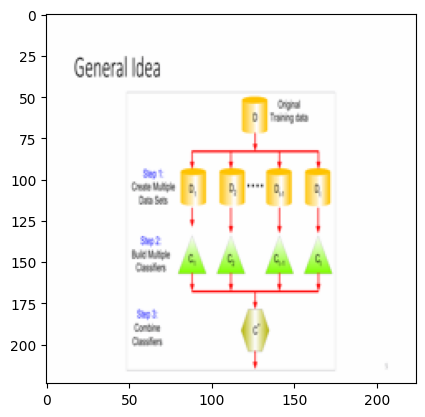

In [ ]:
 show_predition(50,model,test_dataset)

Question:  Can you explain this slide?
Predicted Answer:  how to write a good restaurant review
Actual Answer:  The slide gives three solutions for someone new in town to find a good restaurant: consulting a food critic, reading a random Google review, and averaging multiple Google reviews.


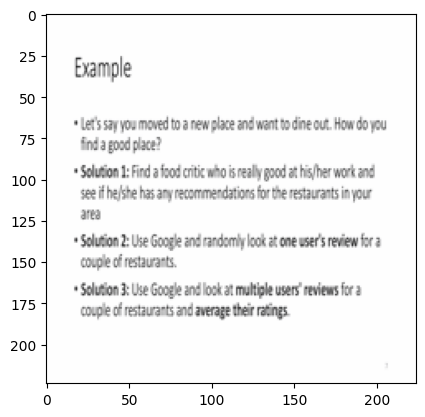

In [ ]:
 show_predition(75,model,test_dataset)

# Can you explain this slide?

## Train

Question: Can you explain this slide?
Predicted Answer:  machine learning basics machine learning is a scientific field concerned with the development of algorithms that can learn
Actual Answer:  It represents the output from the training process, used to make predictions.


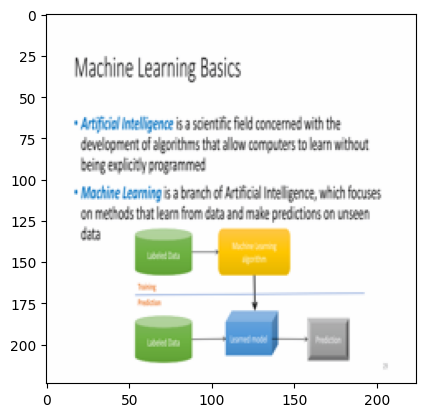

In [ ]:
show_predition(0, model, train_dataset, explain_slide=True)


Question: Can you explain this slide?
Predicted Answer:  a symphony orchestra
Actual Answer:  Attributes that split data well lead to better and more efficient classifications.


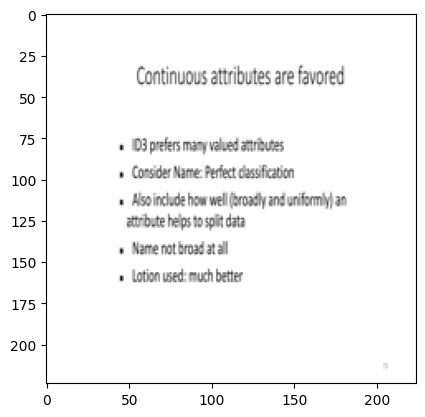

In [ ]:
 show_predition(215,model,train_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  em for gaussian minimums
Actual Answer:  They detail how to compute the updated parameters in the Maximization step.


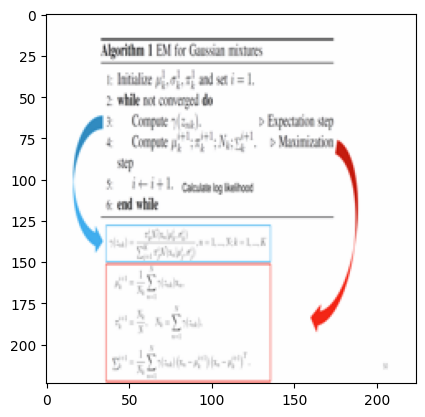

In [ ]:
 show_predition(300,model,train_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  a vision transformer
Actual Answer:  GELU stands for Gaussian Error Linear Unit, used in the Multi-Layer Perceptrons Layer.


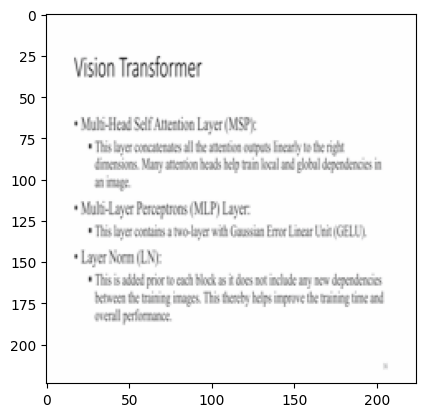

In [ ]:
 show_predition(7740,model,train_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  a simple analogy for EM is a sys
Actual Answer:  The classifying function is represented as f(x) = iyixiTx + b.


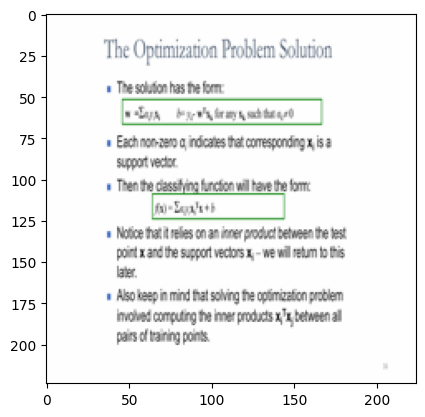

In [ ]:
 show_predition(7000,model,train_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  decision tree as a rule set
Actual Answer:  No, all attributes may not even appear in the tree.


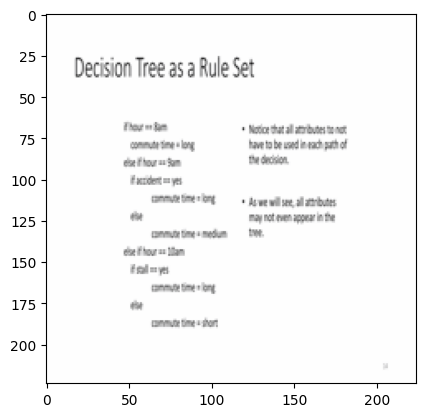

In [ ]:
 show_predition(800,model,train_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  a simple analogy for EM
Actual Answer:  The goal is to minimize the sum of squared differences for best fit.


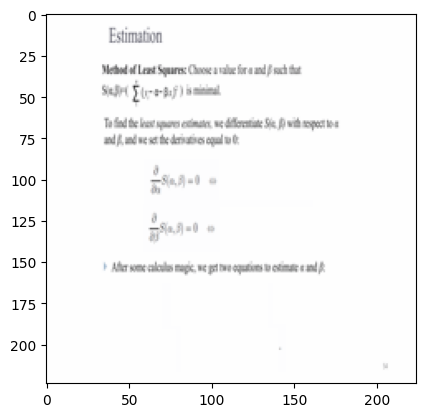

In [ ]:
 show_predition(46,model,train_dataset,explain_slide=True)

Question:  Who developed 'Black & White'?
Predicted Answer:  id in gaming
Actual Answer:  'Black & White' was developed by Lionhead Studios.


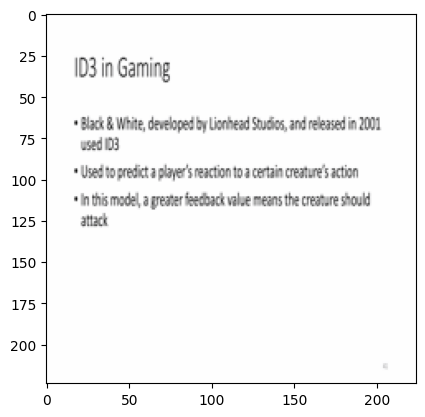

In [ ]:
 show_predition(234, model)

Question:  can you explain this slide?
Predicted Answer:  it emphasizes that it emphasizes that iteratively combines probabilities for different classifiers, leading
Actual Answer:  slide explains linear svm : margin calculated by scalar projection of pos. and neg. examples on unit normal vector. margin width = 2 / | | w | |.


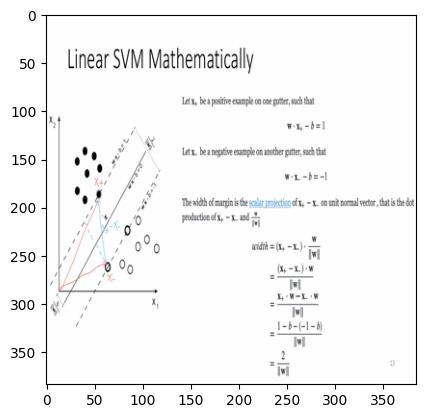

In [ ]:
 show_predition(200, model, explain_slide=True)

Question:  can you explain this slide?
Predicted Answer:  it ensures that it emphasizes that it enhances the algorithm, leading to more accurate and reliable predictions
Actual Answer:  they detail how to compute the updated parameters in the maximization step.


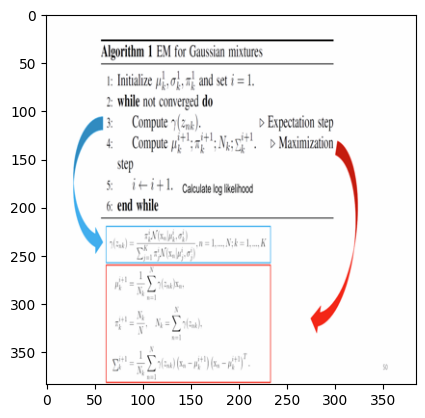

In [ ]:
 show_predition(300, model, explain_slide=True)

Question:  can you explain this slide?
Predicted Answer:  it emphasizes that it emphasizes that it emphasizes that larger it enhances the model's generalization
Actual Answer:  gelu stands for gaussian error linear unit, used in the multi - layer perceptrons layer.


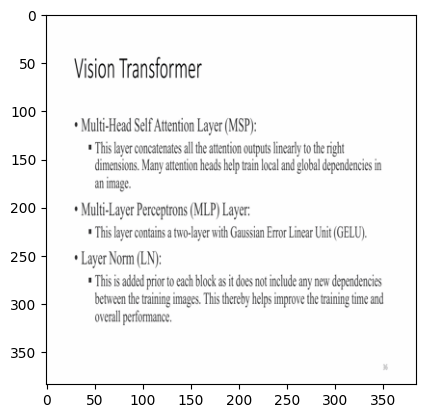

In [ ]:
 show_predition(7740, model, explain_slide=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Question: Can you explain this slide?


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer:  decision tree as a rule set
Actual Answer:  No, all attributes may not even appear in the tree.


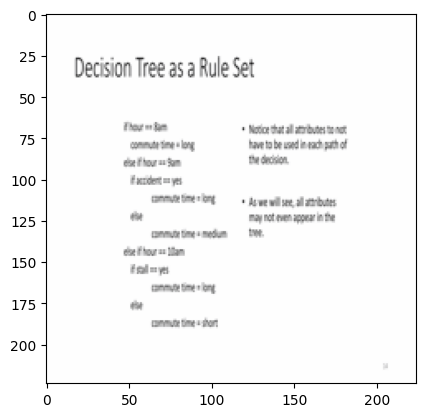

In [ ]:
 show_predition(800,model,train_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  a simple analogy for EM
Actual Answer:  The goal is to minimize the sum of squared differences for best fit.


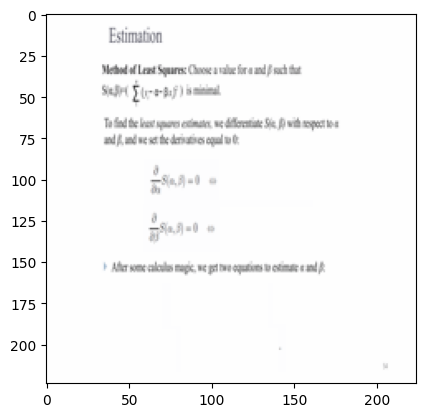

In [ ]:
 show_predition(46,model,train_dataset,explain_slide=True)

## Test

Question: Can you explain this slide?
Predicted Answer:  a) b) c) d) e)
Actual Answer:  It prevents consistent biases across models, making the ensemble more resistant to specific errors.


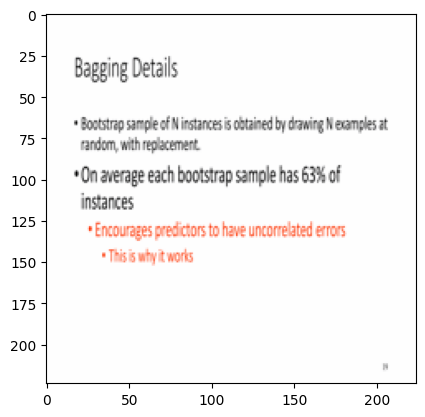

In [ ]:
 show_predition(200,model,test_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  available positions machine learning engineer data scientist
Actual Answer:  Capital One is recruiting for the 'Machine Learning Engineer' position.


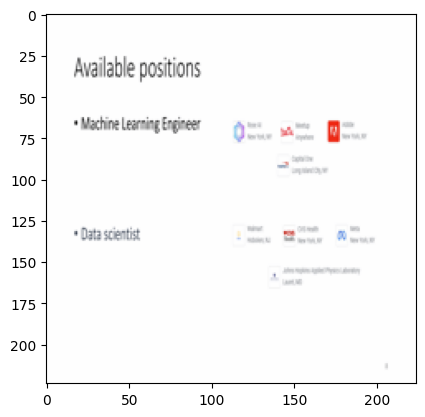

In [ ]:
 show_predition(700,model,test_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  loss functions for x
Actual Answer:  The slide showcases different loss functions, their equations, and their behavior in terms of correct and incorrect classification.


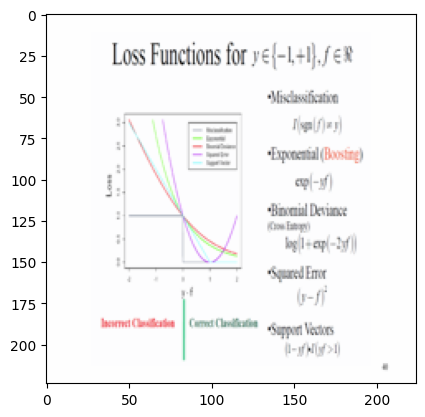

In [ ]:
 show_predition(410,model,test_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  boosting continued 5 a predictor is created by a based sample of training
Actual Answer:  No, boosting doesn't ignore easy instances, but it gives more attention to difficult ones.


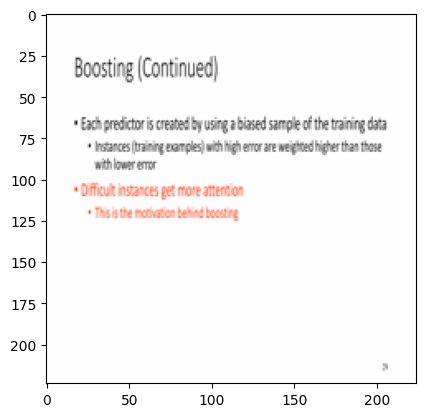

In [ ]:
 show_predition(300,model,test_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  general idea
Actual Answer:  The slide presents the ensemble learning process. It starts with creating multiple datasets, then building multiple classifiers, and finally combining the classifiers for a unified result.


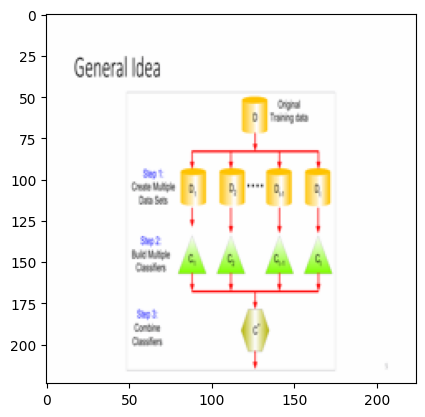

In [ ]:
 show_predition(50,model,test_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  how to write a good restaurant review
Actual Answer:  The slide gives three solutions for someone new in town to find a good restaurant: consulting a food critic, reading a random Google review, and averaging multiple Google reviews.


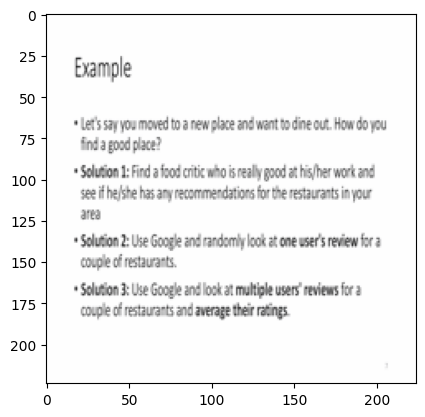

In [ ]:
 show_predition(75,model,test_dataset,explain_slide=True)

# Metrics

In [ ]:
model.eval()

## COSINE SIMILARITY

In [202]:
from torch.nn.functional import cosine_similarity
from tqdm import tqdm
import torch


Test

In [204]:
cosine_similarities = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        generated_indices = model.generate(
            input_ids=inputs['input_ids'],
            pixel_values=inputs['pixel_values'],
            attention_mask=inputs['attention_mask']
        )

        # Ensure generated_indices and labels have compatible dimensions
        if generated_indices.size(1) != labels.size(1):
            if generated_indices.size(1) > labels.size(1):
                generated_indices = generated_indices[:, :labels.size(1)]
            else:
                padding_size = labels.size(1) - generated_indices.size(1)
                padding = torch.zeros((generated_indices.size(0), padding_size), device=labels.device)
                generated_indices = torch.cat([generated_indices, padding], dim=1)

        # Compute cosine similarity for each pair in the batch
        for idx in range(generated_indices.size(0)):
            cos_sim = cosine_similarity(generated_indices[idx].unsqueeze(0), labels[idx].unsqueeze(0))
            cosine_similarities.append(cos_sim.item())


100%|██████████| 8/8 [00:55<00:00,  6.99s/it]


In [205]:
avg_cosine_similarity = np.mean(cosine_similarities)
print("Average Cosine Similarity on Test Data:", avg_cosine_similarity)

Average Cosine Similarity on Test Data: 0.16235583887806124


Train

In [ ]:
cosine_similarities = []
with torch.no_grad():
    for batch in tqdm(train_dataloader):
        print(i)
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        generated_indices = model.generate(
            input_ids=inputs['input_ids'],
            pixel_values=inputs['pixel_values'],
            attention_mask=inputs['attention_mask']
        )

        # Ensure generated_indices and labels have compatible dimensions
        if generated_indices.size(1) != labels.size(1):
            if generated_indices.size(1) > labels.size(1):
                generated_indices = generated_indices[:, :labels.size(1)]
            else:
                padding_size = labels.size(1) - generated_indices.size(1)
                padding = torch.zeros((generated_indices.size(0), padding_size), device=labels.device)
                generated_indices = torch.cat([generated_indices, padding], dim=1)

        # Compute cosine similarity for each pair in the batch
        for idx in range(generated_indices.size(0)):
            cos_sim = cosine_similarity(generated_indices[idx].unsqueeze(0), labels[idx].unsqueeze(0))
            cosine_similarities.append(cos_sim.item())


In [207]:
avg_cosine_similarity = np.mean(cosine_similarities)
print("Average Cosine Similarity on Train Data:", avg_cosine_similarity)

Average Cosine Similarity on Train Data: 0.18304588076275638


## BLEU

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

Test

In [ ]:
bleu_scores = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        generated_indices = model.generate(
            input_ids=inputs['input_ids'],
            pixel_values=inputs['pixel_values'],
            attention_mask=inputs['attention_mask']
        )

        # Convert the generated indices and labels to words
        for idx in range(generated_indices.size(0)):
            ref_sentence = text_processor.decode(labels[idx], skip_special_tokens=True).split()
            gen_sentence = remove_repeated_phrases(text_processor.decode(generated_indices[idx], skip_special_tokens=True)).split()

            # Compute BLEU score for each sentence
            score = sentence_bleu([ref_sentence], gen_sentence, weights=(0.25, 0.25, 0.25, 0.25))
            bleu_scores.append(score)

avg_bleu_score = np.mean(bleu_scores)
print("Average BLEU Score on Test Data:", avg_bleu_score)


  0%|          | 0/147 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore 

Average BLEU Score on Test Data: 0.012054662107680941


In [ ]:
bleu_scores = []
with torch.no_grad():
    for batch in tqdm(train_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        generated_indices = model.generate(
            input_ids=inputs['input_ids'],
            pixel_values=inputs['pixel_values'],
            attention_mask=inputs['attention_mask']
        )

        # Convert the generated indices and labels to words
        for idx in range(generated_indices.size(0)):
            ref_sentence = text_processor.decode(labels[idx], skip_special_tokens=True).split()
            gen_sentence = remove_repeated_phrases(text_processor.decode(generated_indices[idx], skip_special_tokens=True)).split()

            # Compute BLEU score for each sentence
            score = sentence_bleu([ref_sentence], gen_sentence, weights=(0.25, 0.25, 0.25, 0.25))
            bleu_scores.append(score)




In [ ]:
avg_bleu_score = np.mean(bleu_scores)
print("Average BLEU Score on Train Data:", avg_bleu_score)

Average BLEU Score on Train Data: 0.016841741306357693


## Rouge

In [ ]:
from rouge import Rouge
from tqdm import tqdm
import torch

Test

In [ ]:
rouge = Rouge()


In [ ]:
rouge_scores = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        generated_indices = model.generate(
            input_ids=inputs['input_ids'],
            pixel_values=inputs['pixel_values'],
            attention_mask=inputs['attention_mask']
        )

        # Convert the generated indices and labels to text
        for idx in range(generated_indices.size(0)):
            # Assuming tokenizer.decode() method to convert IDs to text
            reference_text = processor.decode(labels[idx], skip_special_tokens=True)
            generated_text = processor.decode(generated_indices[idx], skip_special_tokens=True)
            if generated_text == "":
                generated_text = " "
            # Compute ROUGE score for each sentence
            scores = rouge.get_scores(generated_text, reference_text)
            rouge_scores.append(scores)  # Scores is a dict with 'rouge-1', 'rouge-2', 'rouge-l'

# Calculate average of ROUGE scores
average_rouge_scores = np.mean([score[0]['rouge-1']['f'] for score in rouge_scores])


print("Average ROUGE Scores on Test Data:", average_rouge_scores)


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 8/8 [00:56<00:00,  7.01s/it]

Average ROUGE Scores on Test Data: 0.12038149467955339


In [ ]:
rouge_scores = []
with torch.no_grad():
    for i,batch in enumerate(train_dataloader):
        print(i)
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        generated_indices = model.generate(
            input_ids=inputs['input_ids'],
            pixel_values=inputs['pixel_values'],
            attention_mask=inputs['attention_mask']
        )

        # Convert the generated indices and labels to text
        for idx in range(generated_indices.size(0)):
            # Assuming tokenizer.decode() method to convert IDs to text
            reference_text = processor.decode(labels[idx], skip_special_tokens=True)
            generated_text = processor.decode(generated_indices[idx], skip_special_tokens=True)
            if generated_text == "":
                generated_text = " "
            # Compute ROUGE score for each sentence
            scores = rouge.get_scores(generated_text, reference_text)
            rouge_scores.append(scores)  # Scores is a dict with 'rouge-1', 'rouge-2', 'rouge-l'



In [201]:
# Calculate average of ROUGE scores
average_rouge_scores = np.mean([score[0]['rouge-1']['f'] for score in rouge_scores])


print("Average ROUGE Scores on Train Data:", average_rouge_scores)


Average ROUGE Scores on Train Data: 0.12833928644691875
